In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('/kaggle/input/dataset/dataset.csv')

In [3]:
np.random.seed(42)

## Анализируем

In [4]:
data.info() # данных очень мало, а признаков много

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Columns: 806 entries, 0 to target
dtypes: float64(805), int64(1)
memory usage: 19.7 MB


In [5]:
np.sum(np.sum(data.isna())) # пропусков нет 

0

In [6]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,800,801,802,803,804,target
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,...,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,4.905736,1.004077,4.905259,-16.764958,11.378823,0.985953,0.991219,4.843143,4.818068,1.019979,...,4.971858,1.021051,15.134639,1.001243,66.538199,4.898069,4.927336,25.268862,97.299306,0.168437
std,572.099724,1.006358,572.239569,1144.194017,1166.478566,0.998380,1.021583,586.901682,572.144211,1.021059,...,572.067999,1.006967,0.720456,1.011120,0.722748,572.089702,572.102289,1138.873192,0.721738,0.374313
min,-1985.373872,-0.365879,-1979.222507,-1997.880619,-1999.071536,-0.371556,-0.326992,-1985.977156,-1978.848358,-0.359753,...,-1979.513449,-0.342419,13.738149,-0.267957,65.139060,-1979.963658,-1985.035268,-1998.404272,95.956766,0.000000
25%,1.733205,0.048172,1.689857,-1005.597646,-1005.410989,0.041556,0.044230,1.769651,1.632500,0.053863,...,1.736377,0.052952,14.417427,0.043592,65.809713,1.692510,1.689074,-936.466096,96.601876,0.000000
50%,5.066410,0.966576,5.005792,-33.068556,12.529704,0.961443,0.960883,5.196335,5.050662,0.969711,...,5.113488,0.968487,15.183182,0.968037,66.598725,5.003343,4.963494,22.042498,97.355167,0.000000
75%,8.302775,1.853334,8.283948,986.587994,1039.632650,1.848203,1.857232,8.377849,8.176830,1.865839,...,8.302549,1.882305,15.840340,1.833787,67.234482,8.332029,8.158775,1018.741960,98.005873,0.000000
max,1999.164279,6.018990,1998.083977,1999.948257,1998.248312,5.108544,6.127216,2006.079911,1996.010797,7.010780,...,1997.981103,6.964271,16.347344,5.969353,67.753568,1993.521727,2002.557362,1996.266269,98.530184,1.000000


In [7]:
for i in range(805): # нет категориальных признаков
    if len(data[str(i)].value_counts()) < 3000:
        print(str(i))

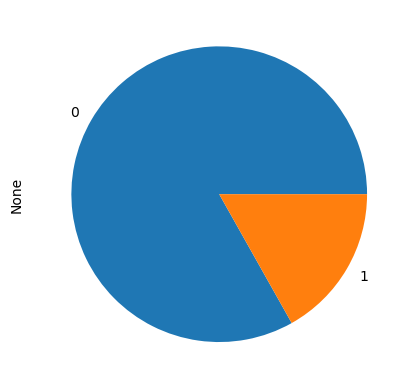

In [8]:
fig, ax = plt.subplots() # несбалансированный таргет 
data.groupby('target').size().plot(kind='pie', ax=ax)
plt.show()

## Готовимся к обучению

In [9]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(columns = ['target']), data['target'], stratify=data['target'], train_size=0.8, random_state=42)

In [10]:
def paint_res(model, X_train, X_val, y_train, y_val):
    y_val_predicted = model.predict_proba(X_val)[:, 1]
    y_train_predicted = model.predict_proba(X_train)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='val AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

## Базовые модели

In [12]:
log_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=10000, penalty = 'l2')
)

parameters = {
    'logisticregression__C'       :  np.logspace(-4, 4, num=9)
}

log_model = GridSearchCV(estimator=log_pipeline, 
                        param_grid=parameters,
                        cv=5, 
                        scoring='roc_auc',
                        verbose=10)
log_model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START logisticregression__C=0.0001................................
[CV 1/5; 1/9] END .logisticregression__C=0.0001;, score=0.562 total time=   0.1s
[CV 2/5; 1/9] START logisticregression__C=0.0001................................
[CV 2/5; 1/9] END .logisticregression__C=0.0001;, score=0.562 total time=   0.1s
[CV 3/5; 1/9] START logisticregression__C=0.0001................................
[CV 3/5; 1/9] END .logisticregression__C=0.0001;, score=0.533 total time=   0.1s
[CV 4/5; 1/9] START logisticregression__C=0.0001................................
[CV 4/5; 1/9] END .logisticregression__C=0.0001;, score=0.550 total time=   0.1s
[CV 5/5; 1/9] START logisticregression__C=0.0001................................
[CV 5/5; 1/9] END .logisticregression__C=0.0001;, score=0.585 total time=   0.1s
[CV 1/5; 2/9] START logisticregression__C=0.001.................................
[CV 1/5; 2/9] END ..logisticregression__C=0.001;,

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5; 9/9] END logisticregression__C=10000.0;, score=0.428 total time=   9.1s
[CV 2/5; 9/9] START logisticregression__C=10000.0...............................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5; 9/9] END logisticregression__C=10000.0;, score=0.479 total time=  10.0s
[CV 3/5; 9/9] START logisticregression__C=10000.0...............................
[CV 3/5; 9/9] END logisticregression__C=10000.0;, score=0.476 total time=   9.6s
[CV 4/5; 9/9] START logisticregression__C=10000.0...............................
[CV 4/5; 9/9] END logisticregression__C=10000.0;, score=0.462 total time=   7.8s
[CV 5/5; 9/9] START logisticregression__C=10000.0...............................
[CV 5/5; 9/9] END logisticregression__C=10000.0;, score=0.494 total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             scoring='roc_auc', verbose=10)

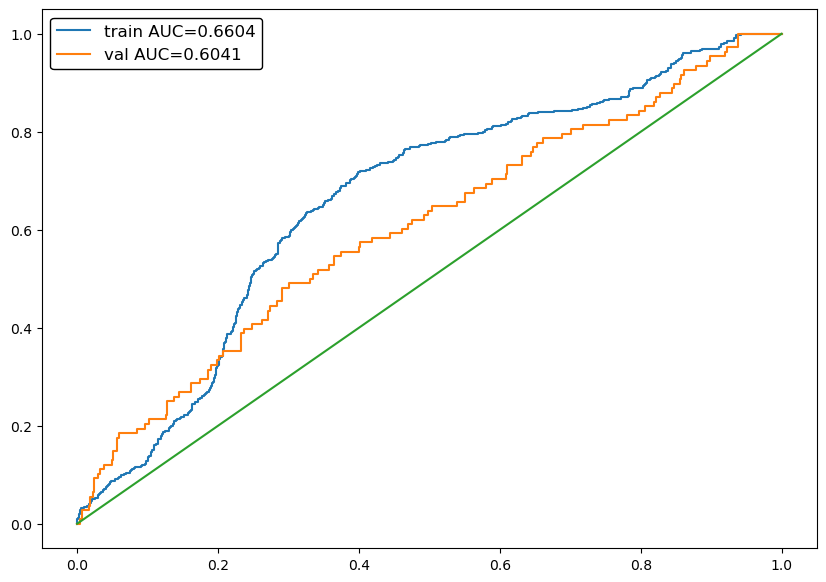

In [13]:
paint_res(log_model, X_train, X_val, y_train, y_val)

In [14]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

Learning rate set to 0.01539
0:	learn: 0.6844679	total: 164ms	remaining: 2m 43s
1:	learn: 0.6761784	total: 236ms	remaining: 1m 57s
2:	learn: 0.6682218	total: 309ms	remaining: 1m 42s
3:	learn: 0.6604209	total: 382ms	remaining: 1m 35s
4:	learn: 0.6525919	total: 453ms	remaining: 1m 30s
5:	learn: 0.6455045	total: 529ms	remaining: 1m 27s
6:	learn: 0.6383464	total: 601ms	remaining: 1m 25s
7:	learn: 0.6312757	total: 671ms	remaining: 1m 23s
8:	learn: 0.6248826	total: 745ms	remaining: 1m 22s
9:	learn: 0.6186396	total: 815ms	remaining: 1m 20s
10:	learn: 0.6122406	total: 887ms	remaining: 1m 19s
11:	learn: 0.6060304	total: 976ms	remaining: 1m 20s
12:	learn: 0.5998830	total: 1.05s	remaining: 1m 20s
13:	learn: 0.5944467	total: 1.13s	remaining: 1m 19s
14:	learn: 0.5888591	total: 1.2s	remaining: 1m 18s
15:	learn: 0.5837765	total: 1.27s	remaining: 1m 18s
16:	learn: 0.5788399	total: 1.35s	remaining: 1m 17s
17:	learn: 0.5739091	total: 1.42s	remaining: 1m 17s
18:	learn: 0.5692860	total: 1.49s	remaining: 1

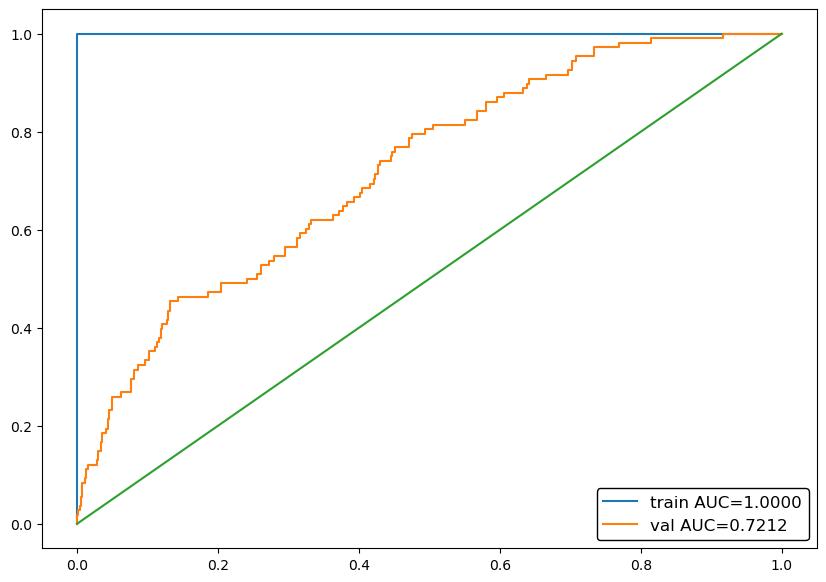

In [15]:
paint_res(cat_model, X_train, X_val, y_train, y_val)

## Рассуждения почему такая модель

Сделала ставку на CatBoost. Теперь хочется уменьшить количество признаков --- PCA. Без новых признаков, повысить метрику не получалось, поэтому их нужно добавить. В итоге каркас финальной модели будет выглядеть как-то так:

? -- то, что будет подбираться GridSearchCV, а остальные параметры были выбраны из других обученных моделей и из вычислительных возможностей компьютера

```
make_pipeline(
    StandardScaler(),
    PCA(n_components=3),
    PolynomialFeatures(degree=3),
    CatBoostClassifier(iterations=?, learning_rate=?, depth=?, eval_metric ='AUC', silent=True)
)
```

In [ ]:
tree = ExtraTreesClassifier(n_estimators=50, random_state=42)
tree.fit(X_train, y_train)
selected_features = np.argsort(tree.feature_importances_)[-300:].astype(str)

In [ ]:
final_pipeline = make_pipeline(
    StandardScaler(),
    PCA(),
    PolynomialFeatures(degree=3),
    CatBoostClassifier(iterations=1000, eval_metric ='AUC', silent=True)
)

parameters = {
    'pca__n_components': [3, 5, 10],
    'catboostclassifier__learning_rate':  np.logspace(-3, -1, num=5),
    'catboostclassifier__depth'       :  [4, 6, 8]
}

final_model = GridSearchCV(estimator=final_pipeline, 
                        param_grid=parameters,
                        cv=3, 
                        scoring='roc_auc',
                        verbose=10)

In [ ]:
final_model.fit(X_train[selected_features], y_train)

In [ ]:
paint_res(final_pipeline, X_train[selected_features], X_val[selected_features], y_train, y_val)

In [ ]:
final_model.best_params_

In [24]:
pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=3),
    PolynomialFeatures(3),
    CatBoostClassifier(iterations=5500, learning_rate=0.009, l2_leaf_reg=1, depth=7, eval_metric ='AUC')
)

In [27]:
pipe.fit(X_train, y_train)

0:	total: 10.6ms	remaining: 58.1s
1:	total: 25.7ms	remaining: 1m 10s
2:	total: 36.4ms	remaining: 1m 6s
3:	total: 45.7ms	remaining: 1m 2s
4:	total: 60.8ms	remaining: 1m 6s
5:	total: 69ms	remaining: 1m 3s
6:	total: 73.6ms	remaining: 57.7s
7:	total: 78.2ms	remaining: 53.7s
8:	total: 82.7ms	remaining: 50.4s
9:	total: 87.4ms	remaining: 48s
10:	total: 92.2ms	remaining: 46s
11:	total: 96.5ms	remaining: 44.2s
12:	total: 101ms	remaining: 42.6s
13:	total: 109ms	remaining: 42.6s
14:	total: 115ms	remaining: 42s
15:	total: 120ms	remaining: 41.1s
16:	total: 125ms	remaining: 40.5s
17:	total: 131ms	remaining: 39.8s
18:	total: 135ms	remaining: 39s
19:	total: 140ms	remaining: 38.4s
20:	total: 145ms	remaining: 37.8s
21:	total: 150ms	remaining: 37.2s
22:	total: 155ms	remaining: 36.9s
23:	total: 160ms	remaining: 36.4s
24:	total: 164ms	remaining: 36s
25:	total: 170ms	remaining: 35.8s
26:	total: 176ms	remaining: 35.6s
27:	total: 181ms	remaining: 35.4s
28:	total: 187ms	remaining: 35.2s
29:	total: 191ms	remain

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x795dc848d750>)])

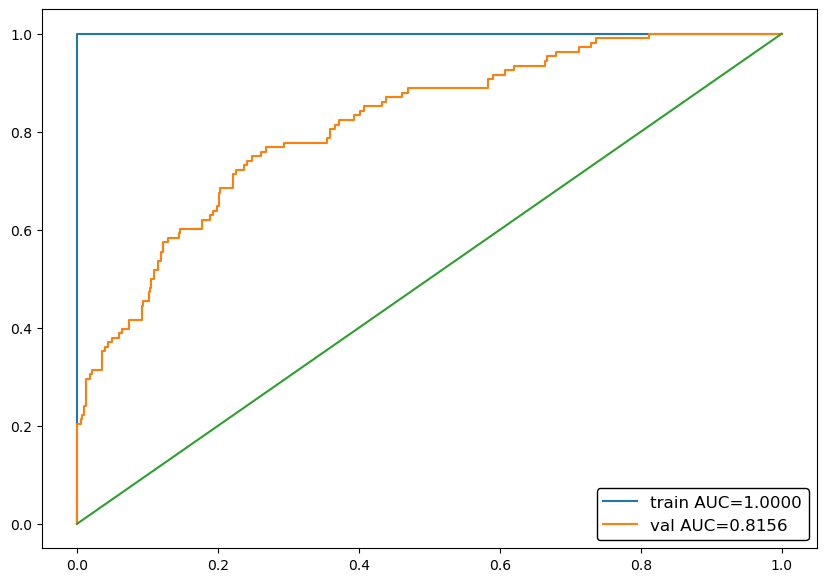

In [29]:
paint_res(pipe, X_train, X_val, y_train, y_val)

## Дообучение и печать результатов

In [30]:
result_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=3),
    PolynomialFeatures(3),
    CatBoostClassifier(iterations=5500, learning_rate=0.009, l2_leaf_reg=1, depth=7, eval_metric ='AUC')
)

In [31]:
result_pipeline.fit(data.drop(columns = ['target']), data['target'])

0:	total: 9.86ms	remaining: 54.2s
1:	total: 23ms	remaining: 1m 3s
2:	total: 35.1ms	remaining: 1m 4s
3:	total: 47.7ms	remaining: 1m 5s
4:	total: 56.2ms	remaining: 1m 1s
5:	total: 61.3ms	remaining: 56.1s
6:	total: 66.4ms	remaining: 52.1s
7:	total: 71.7ms	remaining: 49.2s
8:	total: 76.4ms	remaining: 46.6s
9:	total: 81.8ms	remaining: 44.9s
10:	total: 90.3ms	remaining: 45s
11:	total: 96.2ms	remaining: 44s
12:	total: 101ms	remaining: 42.8s
13:	total: 106ms	remaining: 41.7s
14:	total: 112ms	remaining: 40.8s
15:	total: 117ms	remaining: 40s
16:	total: 122ms	remaining: 39.3s
17:	total: 127ms	remaining: 38.8s
18:	total: 133ms	remaining: 38.3s
19:	total: 138ms	remaining: 37.8s
20:	total: 143ms	remaining: 37.2s
21:	total: 148ms	remaining: 36.8s
22:	total: 153ms	remaining: 36.4s
23:	total: 158ms	remaining: 36.1s
24:	total: 164ms	remaining: 35.8s
25:	total: 169ms	remaining: 35.6s
26:	total: 174ms	remaining: 35.3s
27:	total: 180ms	remaining: 35.1s
28:	total: 184ms	remaining: 34.8s
29:	total: 189ms	rem

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x795dc8389210>)])

In [33]:
test = pd.read_csv('/kaggle/input/dataset-test/test.csv')

In [46]:
predictions = result_pipeline.predict(test.drop(columns = ['id']))

In [52]:
sumb = pd.DataFrame()
sumb['id'] = test['id']
sumb['target'] = predictions
sumb.to_csv('submission.csv')